In [46]:
from funcoes.funcoes import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [47]:
LC_defaults = pd.read_csv('dados/dados_WoE_VI_LGD_EAD_regressao.csv')

# Modelo Índice de Perda por Inadimplência
---

In [49]:
# separando dados

X = LC_defaults.drop(['target', 'taxa_recuperacao', 'taxa_recuperacao_0_1', 'fator_conversao_credito', 'funded_amnt', 'total_rec_prncp', 'recoveries'], axis = 1)
y = LC_defaults['taxa_recuperacao_0_1']

In [50]:
# separando dados de teste e treino
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [51]:
# Instanciando a função

scaler = StandardScaler()


# Transformando os dados

Xtrain_scaled = scaler.fit_transform(X_train1)
Xtest_scaled = scaler.transform(X_test1)

### Regressão Logística - Parte 1

In [52]:
reglgd1 = LogisticRegression_p_values()
reglgd1.fit(X_train1, y_train1)

In [53]:
nomes_features = X_train1.columns.values

In [54]:
tabela_sumario = pd.DataFrame(columns = ['nome_feature'], data = nomes_features)
tabela_sumario['coeficiente'] = np.transpose(reglgd1.coef_)
tabela_sumario.index = tabela_sumario.index + 1
tabela_sumario.loc[0] = ['intercept', reglgd1.intercept_[0]]
tabela_sumario = tabela_sumario.sort_index()

p_values = reglgd1.p_values
p_values = np.append(np.nan, np.array(p_values))
tabela_sumario['p_valor'] = p_values
tabela_sumario

,nome_feature,coeficiente,p_valor
0,intercept,0.701567,NaN
1,grade:A,-1.057583,1.950813e-11
2,grade:B,-0.873376,6.622634e-24
3,grade:C,-0.664666,5.270324e-17
4,grade:D,-0.417188,2.965556e-08
...,...,...,...
100,mths_since_last_record:3-20,-0.068904,7.224298e-01
101,mths_since_last_record:21-31,-0.109482,5.375878e-01
102,mths_since_last_record:32-80,-0.166915,1.797937e-01
103,mths_since_last_record:81-86,0.059009,7.035614e-01


#### Testando o modelo

In [55]:
y_pred_test1  = reglgd1.model.predict(X_test1)
y_test_proba1 = reglgd1.model.predict_proba(X_test1)

In [56]:
y_test_proba1 = y_test_proba1[: ][: , 1]

In [57]:
y_test1_temp = y_test1

y_test1_temp.reset_index(drop = True, inplace = True)
df_pred_probs_atual = pd.concat([pd.DataFrame(y_test1_temp), pd.DataFrame(y_test_proba1)], axis = 1)
df_pred_probs_atual.columns = ['y_test1', 'y_test_proba1']
df_pred_probs_atual.index = X_test1.index
df_pred_probs_atual.head()

,y_test1,y_test_proba1
362514,0.0,0.022261
288564,0.0,0.026238
213591,0.0,0.076850
263083,0.0,0.006678
165001,0.0,0.018820


#### Estimando o acurácia do modelo

In [58]:
tr = 0.5
df_pred_probs_atual['y_pred_test1'] = np.where(df_pred_probs_atual['y_test_proba1'] > tr, 1, 0)

In [59]:
pd.crosstab(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_pred_test1'], rownames = ['atual'], colnames = ['predito'])

predito,0,1
atual,,
0.0,132526,1
1.0,7359,0


In [60]:
pd.crosstab(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_pred_test1'], 
            rownames = ['atual'], colnames = ['predito']) / df_pred_probs_atual.shape[0]

predito,0,1
atual,,
0.0,0.947386,0.000007
1.0,0.052607,0.000000


In [61]:
(pd.crosstab(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_pred_test1'], rownames = ['atual'], colnames = ['predito']) / df_pred_probs_atual.shape[0]).iloc[0, 0] + (pd.crosstab(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_pred_test1'], rownames = ['atual'], colnames = ['predito']) / df_pred_probs_atual.shape[0]).iloc[1, 1]

0.9473857283788227

In [62]:
tfp, tvp, thresholds = roc_curve(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_test_proba1'])

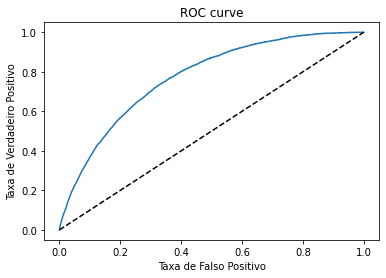

In [63]:
plt.plot(tfp, tvp)
plt.plot(tfp, tfp, linestyle = '--', color = 'k')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC curve');

In [64]:
AUROC = roc_auc_score(df_pred_probs_atual['y_test1'], df_pred_probs_atual['y_test_proba1'])
AUROC

0.7716530111487212

In [65]:
y_pred_train1 = reglgd1.model.predict(X_train1)
y_pred_train1

array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
print('Acurácia de teste: {0:0.4f}'.format(accuracy_score(y_test1, y_pred_test1)))
print('Acurácia de treino: {0:0.4f}'.format(accuracy_score(y_train1, y_pred_train1)))

Acurácia de teste: 0.9474
Acurácia de treino: 0.9479


Comparação da precisão do conjunto de treino e do conjunto de teste para verificar se há overfitting. Como os valores são próximos, não há overfiting (uma grande diferença nos dois valores pode indicar overfitting ou underfitting). 

In [67]:
print('Score de treino: {:.4f}'.format(reglgd1.model.score(X_train1, y_train1)))
print('Score de teste: {:.4f}'.format(reglgd1.model.score(X_test1, y_test1)))

Score de treino: 0.9479
Score de teste: 0.9474


In [68]:
print(classification_report(y_test1, y_pred_test1))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    132527
         1.0       0.00      0.00      0.00      7359

    accuracy                           0.95    139886
   macro avg       0.47      0.50      0.49    139886
weighted avg       0.90      0.95      0.92    139886



#### Salvando o modelo

In [69]:
import pickle
pickle.dump(reglgd1, open('modelos/modelo_lgd_v1.sav', 'wb'))

### Resultados

- A acurácia do modelo de regressão logística foi de 62% e a ROC-AUC de 66%. Assim, pode-se concluir que o classificador consegue prever a taxa de recuperação, sem mostrar sinais de overfitting;
    
- F-1 score: 60%, Recall: 71%

### Regressão Linear - Parte 2

In [70]:
LC_defaults2 = LC_defaults[LC_defaults['taxa_recuperacao_0_1'] == 1]

In [71]:
# separando dados

X2 = LC_defaults2.drop(['target', 'taxa_recuperacao','taxa_recuperacao_0_1', 'fator_conversao_credito', 'funded_amnt', 'total_rec_prncp', 'recoveries'] , axis = 1)
y2 = LC_defaults2['taxa_recuperacao']

In [72]:
# separando dados de teste e treino

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 42)

In [73]:
# Instanciando a função

scaler = StandardScaler()


# Transformando os dados

Xtrain_scaled = scaler.fit_transform(X_train2)
Xtest_scaled = scaler.transform(X_test2)

In [74]:
reglgd2 = LinearRegression()
reglgd2.fit(X_train2, y_train2)

LinearRegression()

In [75]:
nomes_features = X_train2.columns.values

In [76]:
tabela_sumario = pd.DataFrame(columns = ['nome_feature'], data = nomes_features)
tabela_sumario['coeficiente'] = np.transpose(reglgd2.coef_)
tabela_sumario.index = tabela_sumario.index + 1
tabela_sumario.loc[0] = ['intercept', reglgd2.intercept_]
tabela_sumario = tabela_sumario.sort_index()

p_values = reglgd2.p
p_values = np.append(np.nan,np.array(p_values))
tabela_sumario['p_valor'] = p_values.round(3)
tabela_sumario

,nome_feature,coeficiente,p_valor
0,intercept,0.574354,NaN
1,grade:A,0.011603,0.411
2,grade:B,0.002980,0.672
3,grade:C,0.002362,0.712
4,grade:D,0.000467,0.938
...,...,...,...
100,mths_since_last_record:3-20,-0.018271,0.272
101,mths_since_last_record:21-31,-0.013049,0.380
102,mths_since_last_record:32-80,-0.011027,0.273
103,mths_since_last_record:81-86,-0.009060,0.474


#### Avaliação da regressão linear

In [77]:
y_pred_test2 = reglgd2.predict(X_test2)

In [78]:
# baixa correlação, mas satisfatórica para um modelo LGD
# caso a correlação fosse muito alta, o modelo teria que ser refeito

y_test_temp2 = y_test2
y_test_temp2 = y_test_temp2.reset_index(drop = True)
pd.concat([pd.DataFrame(y_test_temp2), pd.DataFrame(y_pred_test2)], axis = 1).corr()

,taxa_recuperacao,0
taxa_recuperacao,1.000000,0.328278
0,0.328278,1.000000


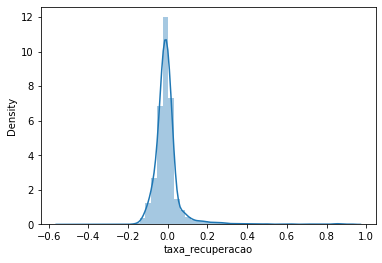

In [79]:
# distribuição concentrada perto de zero, condizendo com os dados
# então o modelo é aceitável metodologicamente

sns.distplot(y_test2 - y_pred_test2);

O valor RMSE foi encontrado para ser 0.10. Isso significa que o desvio padrão para nossa previsão é 0.10. 

In [80]:
# RMSE (Root Mean Square Error)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test2, y_pred_test2)
rmse = np.sqrt(mse)
print("RMSE value : {:.2f}".format(rmse))

RMSE value : 0.09


In [81]:
# verificando over ou underfiting

print('Score de treino: {:.4f}'.format(reglgd2.score(X_train2, y_train2)))
print('Score de teste: {:.4f}'.format(reglgd2.score(X_test2, y_test2)))

Score de treino: 0.1222
Score de teste: 0.1067


#### Salvando o modelo

In [82]:
import pickle
pickle.dump(reglgd2, open('modelos/modelo_lgd_v2.sav', 'wb'))

### Combinando os modelos

Na regressão logística o valor da taxa de recuperação foi classificado em 1 ou 0, e nos casos em que era 1, seu valor foi predito pela regressão linear. 

In [83]:
y_pred_test_comb = reglgd2.predict(X_test1)

In [84]:
y_pred_test_comb

array([0.13812495, 0.19484484, 0.06684499, ..., 0.15422688, 0.15176015,
       0.09409736])

Combinando as estimações dos modelos multiplicando os valores preditos. 

In [85]:
y_hat_test_lgd = df_pred_probs_atual.y_pred_test1 * y_pred_test_comb

Valores máximos e mínimos dentro dos valores que deveriam ser preditos, 1 e 0.

In [86]:
pd.DataFrame(y_hat_test_lgd).describe()

,y_pred_test1
count,1.398860e+05
mean,6.041999e-07
std,2.259788e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,8.451910e-02


---